In [1]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'

import pandas as pd
import numpy as np
import shutil
import itertools
import statannot

import glob
import re
import seaborn as sns
import statsmodels.api as sm
import statsmodels
import scipy
import nideconv
from nideconv import GroupResponseFitter
from scipy import signal
import statsmodels.formula.api as smf

import pickle as pkl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.backends.backend_pdf

%matplotlib inline

def flatten(t):
    return [item for sublist in t for item in sublist]

/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


## functions

In [2]:
def to_psc(x): # calculate percent signal change
    return x / x.mean() * 100 - 100

def load_events_confounds(sub, dataset, task, run, include_physio=True, include_cosines=True):
    event_fn = f'../derivatives/event_files/{dataset}/sub-{sub}/func/sub-{sub}_task-{task}_run-{run}_events.tsv'
#    regressor_fn = f'../derivatives/behavior/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run}_desc-model-regressors.tsv'
    confounds_fn = f'../derivatives/fmriprep/{dataset}/fmriprep/fmriprep/sub-{sub}/func/sub-{sub}_task-{task}_run-{run}_desc-confounds_timeseries.tsv'
    
    events = pd.read_csv(event_fn, sep='\t', index_col=None)
    events['duration'] = .001
    events['dataset'] = dataset       
        
    # get confounds, cosines
    confounds = pd.read_csv(confounds_fn, sep='\t').fillna(method='bfill')
    include_confs = ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'dvars', 'framewise_displacement', 'global_signal']
    if include_cosines:
        include_confs += [x for x in confounds.columns if 'cos' in x]
    confounds = confounds[include_confs]
    
#     if include_physio:
#         run_idx = run#+1
#         # just use acompcor
#         a_comp_cor = pd.read_csv(confounds_fn, sep='\t')[['a_comp_cor_' + str(x).zfill(2) for x in range(20)]]
        
    if include_physio:        
        run_idx = run#+1
        # just use acompcor
        # some subjects have less than 20 acompcor components, so just take max amount if not more than 20
#         a_comp_cor = pd.read_csv(confounds_fn, sep='\t')[['a_comp_cor_' + str(x).zfill(2) for x in range(20)]]
        a_comp_cor = pd.read_csv(confounds_fn, sep='\t')
        if num_acomp:=len([col for col in a_comp_cor.columns if 'a_comp_cor_' in col]) < 20:
            a_comp_cor = a_comp_cor[['a_comp_cor_' + str(x).zfill(2) for x in range(num_acomp)]]
        else: # use normal 20
            a_comp_cor = a_comp_cor[['a_comp_cor_' + str(x).zfill(2) for x in range(20)]]
        confounds = pd.concat([confounds, a_comp_cor], axis=1)

    return events, confounds

def sort_data(df, ses, task):
    
    all_events = []
    all_confounds = []

    for sub, run in df.reset_index().set_index(['sub', 'run']).index.unique():
    #     if sub == '010' and run == '2':    # no RETROICOR
    #         continue
#         if sub == '007' and run == '1':    # no RETROICOR
#             continue
        events, confounds = load_events_confounds(sub, ses, task, run, include_physio=True)
        events['sub'] = sub
        events['run'] = run
        confounds['sub'] = sub
        confounds['run'] = run

        all_events.append(events)
        all_confounds.append(confounds)

    events = pd.concat(all_events).set_index(['sub', 'run'])
    confounds = pd.concat(all_confounds).set_index(['sub', 'run'])

    events = events.rename(columns={'trial_type': 'event_type'})

    events['duration'] = 0.001  # stick function
        
    # make psc
    confounds['global_signal'] = (confounds['global_signal']-confounds['global_signal'].mean())/confounds['global_signal'].std()

    # change subject number ordering
    subs = df.reset_index()['sub'].unique()
    mapping = {y:x+1 for x,y in enumerate(subs)}

    events = events.reset_index()
    events['sub'] = events['sub'].replace(mapping).astype(str)
    events = events.set_index(['sub', 'run'])

    df = df.reset_index()
    df['sub'] = df['sub'].replace(mapping).astype(str)
    df = df.set_index(['sub', 'run', 'time'])

    confounds = confounds.reset_index()
    confounds['sub'] = confounds['sub'].replace(mapping).astype(str)
    confounds = confounds.set_index(['sub', 'run'])

    events.index = events.index.rename('subject', level=0)
    df.index = df.index.rename('subject', level=0)
    confounds.index = confounds.index.rename('subject', level=0)
    
    return events, df, confounds


In [3]:
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

## start running

In [4]:
# # which dataset?
# dataset = 'Leipzig_7T_SM'
# # dataset = 'Leipzig_7T_GdH'
# # dataset = 'NTNU_7T_SJSI'd
# datasets = ['Leipzig_7T_SM', 'NTNU_7T_SJSI','Leipzig_7T_GdH','openfmri_3T','aron_3T']
# tasks = ['stop','sst','stop','stopsignal','stopsignal']
# trs = [2.0,1.38,3.0,2.0,2.0]

In [5]:
def fetch_dataset_info(dataset):

    if dataset == 'Leipzig_7T_GdH':
        task = 'stop'
        t_r = 2.0
        runs = [1,2,3]
        excluded_runs = [('GAIT',task, '2'),
                     ('GAIT',task, '3'),
                     ('NM3T',task, '2'),
                     ('PF5T',task, '1')]

    elif dataset == 'Leipzig_7T_SM':
        task = 'stop'
        t_r = 3.0
        runs = [1,2,3]
        excluded_runs = [('12',task,'1'),
                         ('12',task,'2'),
                         ('12',task,'3'),
                         ('17',task,'3')] # already removed from data

    elif dataset == 'NTNU_7T_SJSI':
        task = 'sst'
        t_r = 1.38
        runs = [1,2]
        excluded_runs = []

    elif dataset == 'aron_3T':
        task = 'stopsignal'
        t_r = 2.0
        runs = [1,2,3]
        excluded_runs = []

    elif dataset == 'openfmri_3T':
        task = 'stopsignal'
        t_r = 2.0
        runs = [1]
        excluded_runs = [('10570',task,'1')]
        
    return task, t_r, runs, excluded_runs

In [6]:
## Load timeseries
atlas_type = 'ALL'
datasets = ['Leipzig_7T_SM', 'NTNU_7T_SJSI','Leipzig_7T_GdH','openfmri_3T','aron_3T']
dfs = []

for dataset in datasets:

    task, t_r, runs, excluded_runs = fetch_dataset_info(dataset)
    print(dataset)
    
    signal_fns = sorted(glob.glob(f'../derivatives/extracted_signals/{dataset}/sub-*/func/*task-{task}*{atlas_type}*hp.tsv'))
    #signal_fns

    filter_out_confounds = True # remove the confounds first
    filter_hp = False # already highpassed so no need

    regex = re.compile(f'.*sub-(?P<sub>[a-zA-Z0-9]+)_task-(?P<task>\S+)_run-(?P<run>\d)_desc-{atlas_type}-signals_hp.tsv')
    
    for signal_fn in signal_fns:
        
        signals = pd.read_csv(signal_fn, sep='\t',index_col=0)
        signals = signals.loc[:, ~signals.columns.str.contains('^Unnamed')]
        gd = regex.match(signal_fn).groupdict()
        
        if tuple(gd.values()) in excluded_runs: # run was excluded
            print(tuple(gd.values()))
            continue

        if 'time' in signals.columns: # if there's a column named 'time', it's called 'time' but it's really volume number..
            signals = signals.rename(columns={'time': 'volume'})
            
        signals = signals.set_index('volume')
        signals = signals.apply(to_psc)  # to PSC

        if filter_out_confounds: # filter out confounds?
            _, confounds = load_events_confounds(sub=gd['sub'], dataset=dataset, task=gd['task'], run=gd['run'])
            confounds['intercept'] = 1   # add intercept!
            betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signals,rcond=-1)
            signals_hat = confounds@betas
            signals_hat.index = signals.index
            signals_hat.columns = signals.columns
            signals -= signals_hat # residuals
        
        if filter_hp: # high pass?
            signals = signals.apply(lambda x: butter_highpass_filter(x, cutoff=1/128, fs=1/t_r) + x.mean(), axis=0)

        # index to time
        signals.index *= t_r
        signals.index.name = 'time'
        signals['subject'] = gd['sub']
        signals['run'] = int(gd['run'])

        signals['dataset'] = dataset
        signals = signals.reset_index().set_index(['dataset','subject', 'run', 'time'])
        dfs.append(signals)
        
    df = pd.concat(dfs)
    df = df.reindex(sorted(df.columns), axis=1)

if atlas_type == 'ALL': # all cortical masks from harvard-oxford atlas, all subcortical masks from MASSP atalas
    
    df.rename(columns = {'lM1':'M1-l', 'rM1':'M1-r', 'gpel':'GPe-l','gper':'GPe-r','gpil':'GPi-l','gpir':'GPi-r',
                         'rnl':'RN-l','rnr':'RN-r','snl':'SN-l','snr':'SN-r','stnl':'STN-l','stnr':'STN-r',
                         'strl':'Str-l','strr':'Str-r','thal':'Tha-l','thar':'Tha-r','vtal':'VTA-l','vtar':'VTA-r'}, inplace = True)
    
    rois_ = ['IFG','SMA','M1','SN','STN','GPe','Tha']
    rois_ = [roi + '-' + hemi for roi in rois_ for hemi in ['l', 'r']]
    
    df = df[rois_]
    
os.makedirs(timeseries_dir:=f'../derivatives/hierarchical_roi_glm/all_datasets/timeseries', exist_ok=True)
with open(os.path.join(timeseries_dir, f'all_datasets_timeseries.pkl'), 'wb') as f:
            pkl.dump('', f)
with open(os.path.join(timeseries_dir, f'all_datasets_timeseries.pkl'), 'wb') as f:
            pkl.dump(df, f)

df.head()



Leipzig_7T_SM
NTNU_7T_SJSI
Leipzig_7T_GdH
('GAIT', 'stop', '2')
('GAIT', 'stop', '3')
('NM3T', 'stop', '2')
('PF5T', 'stop', '1')
openfmri_3T
('10570', 'stopsignal', '1')
aron_3T


IFG-l     IFG-r     SMA-l     SMA-r  \
dataset       subject run time                                           
Leipzig_7T_SM 01      1   0.0  -0.146238 -0.262955 -0.042092 -0.214761   
                          3.0  -0.174954  0.122178 -0.330544 -0.003729   
                          6.0   0.072229  0.479801  0.076712  0.626687   
                          9.0  -0.041200  0.079735 -0.319139 -0.080897   
                          12.0  0.161344  0.106289 -0.096594 -0.110687   

                                    M1-l      M1-r      SN-l      SN-r  \
dataset       subject run time                                           
Leipzig_7T_SM 01      1   0.0  -0.054359 -0.239146 -0.467215 -0.299290   
                          3.0  -0.384997 -0.205802  0.787050  0.369010   
                          6.0   0.089941  0.325921  0.784691  0.083234   
                          9.0  -0.504559  0.058475  0.102067  0.416900   
                          12.0 -0.083782 -0.009956 -0.046895  0.052136   

                                   STN-l     STN-r     GPe-l     GPe-r  \
dataset       subject run time                                           
Leipzig_7T_SM 01      1   0.0   0.428079  0.128713 -0.358789  0.001497   
                          3.0   0.464705  0.862651  0.521979  0.186003   
                          6.0   0.228708  0.237936  0.195315  0.228836   
                          9.0   0.288984  0.448567  0.628743  0.222020   
                          12.0  1.033918  1.082139 -0.030138 -0.317629   

                                   Tha-l     Tha-r  
dataset       subject run time                      
Leipzig_7T_SM 01      1   0.0  -0.289655 -0.234201  
                          3.0   0.098565  0.214908  
                          6.0  -0.039490  0.028545  
                          9.0   0.103837  0.038454  
                          12.0  0.127137 -0.096869

# load events, confounds

In [7]:
model_n = 'all_events'
all_events = []
all_confounds = []

for dataset in datasets:
    print(dataset)
    for dataset, sub, run in df.reset_index().set_index(['dataset','subject', 'run']).index.unique():
        task, t_r, runs, excluded_runs = fetch_dataset_info(dataset)
        events, confounds = load_events_confounds(sub, dataset, task, run, include_physio=True)
        events['subject'] = sub
        events['run'] = run
        confounds['subject'] = sub
        confounds['run'] = run
        confounds['dataset'] = dataset

        all_events.append(events)
        all_confounds.append(confounds)

confounds = pd.concat(all_confounds)
confounds= confounds.set_index(['dataset','subject', 'run'])

events = pd.concat(all_events).set_index(['dataset','subject', 'run'])
events = events.rename(columns={'trial_type': 'event_type'})
events['duration'] = 0.001  # stick function

os.makedirs(event_dir:=f'../derivatives/hierarchical_roi_glm/all_datasets/events', exist_ok=True)
with open(os.path.join(event_dir, f'all_datasets_events.pkl'), 'wb') as f:
            pkl.dump('', f)
with open(os.path.join(event_dir, f'all_datasets_events.pkl'), 'wb') as f:
            pkl.dump(events, f)
        
os.makedirs(confound_dir:=f'../derivatives/hierarchical_roi_glm/all_datasets/confounds', exist_ok=True)
with open(os.path.join(confound_dir, f'all_datasets_confounds.pkl'), 'wb') as f:
            pkl.dump('', f)
with open(os.path.join(confound_dir, f'all_datasets_confounds.pkl'), 'wb') as f:
            pkl.dump(confounds, f)

Leipzig_7T_SM
NTNU_7T_SJSI
Leipzig_7T_GdH
openfmri_3T
aron_3T


In [6]:
df = pd.read_pickle(f'../derivatives/hierarchical_roi_glm/all_datasets/timeseries/all_datasets_timeseries.pkl')
events = pd.read_pickle(f'../derivatives/hierarchical_roi_glm/all_datasets/events/all_datasets_events.pkl')
confounds = None
t_r = 1000 # do this so i know if things are still going wrong
atlas_type = 'ALL'
rois_ = ['IFG','SMA','M1','SN','STN','GPe','Tha']
rois_ = [roi + '-' + hemi for roi in rois_ for hemi in ['l', 'r']]

## glm function

In [7]:
def fit_glm(timeseries, events, confounds, include_events, include_rois, t_r=t_r, oversample_design_matrix=10, concatenate_runs=False, fit_type='ols'):
    
    # slice time correction for all datasets
    events.loc[events.index.get_level_values(0)=='Leipzig_7T_GdH','onset'] -= 2.0/2
    events.loc[events.index.get_level_values(0)=='Leipzig_7T_SM','onset'] -= 3.0/2
    events.loc[events.index.get_level_values(0)=='NTNU_7T_SJSI','onset'] -= 1.38/2
    events.loc[events.index.get_level_values(0)=='aron_3T','onset'] -= 2.0/2
    events.loc[events.index.get_level_values(0)=='openfmri_3T','onset'] -= 2.0/2
    
    events_1 = events.reset_index().set_index(['dataset','subject', 'run', 'event_type']).loc[(slice(None), slice(None), slice(None),include_events),:]
    events_1 = events_1.reset_index().set_index(['dataset','subject', 'run', 'event_type'])
#     events_1.onset -= t_r/2   # stc

    glm1 = GroupResponseFitter(timeseries.copy()[include_rois],
                               events_1, 
                               confounds=confounds.copy().reset_index() if confounds is not None else None,
                               input_sample_rate=1/t_r, 
                               oversample_design_matrix=oversample_design_matrix,
                               concatenate_runs=concatenate_runs)
    
    for event_type in include_events:

        glm1.add_event(event_type, basis_set='canonical_hrf_with_time_derivative',  interval=[0, 20])

    glm1.fit(type=fit_type)
    return glm1

In [8]:
# def fit_glm(timeseries, events, confounds, include_events, include_rois, t_r=t_r, oversample_design_matrix=10, concatenate_runs=False, fit_type='ols'):
#     events_1 = events.reset_index().set_index(['subject', 'run', 'event_type']).loc[(slice(None), slice(None), include_events),:]
#     events_1 = events_1.reset_index().set_index(['subject', 'run', 'event_type'])
#     events_1.onset -= t_r/2   # stc

#     glm1 = GroupResponseFitter(timeseries.copy()[include_rois],
#                                events_1, 
#                                confounds=confounds.copy().reset_index() if confounds is not None else None,
#                                input_sample_rate=1/t_r, 
#                                oversample_design_matrix=oversample_design_matrix,
#                                concatenate_runs=concatenate_runs)
    
#     for event_type in include_events:

#         glm1.add_event(event_type, basis_set='canonical_hrf_with_time_derivative',  interval=[0, 20])

#     glm1.fit(type=fit_type)
#     return glm1

# fit event glm

In [8]:
confounds = None

if atlas_type == 'ALL':
    gm_nuclei = ['IFG','SMA','M1','SN','STN','GPe','Tha']
    include_rois = [roi + '-' + hemi for roi in gm_nuclei for hemi in ['l', 'r']]

include_events = ['fs','ss','go']

glm1 = fit_glm(timeseries=df, events=events, confounds=confounds, include_events=include_events, include_rois=include_rois, t_r=t_r)

/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:87: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.response_fitters = pd.Series(index=index)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((regressor.X, self.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((regressor.X, self.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all 

/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((regressor.X, self.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((regressor.X, self.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((regressor.X, self.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argum

/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((regressor.X, self.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((regressor.X, self.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((regressor.X, self.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argum

/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((regressor.X, self.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((regressor.X, self.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((regressor.X, self.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argum

/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((regressor.X, self.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((regressor.X, self.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((regressor.X, self.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argum

/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/n

/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/n

/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0. 18.].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-p

/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0. 18.].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0. 18.].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas a

/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0. 18.].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0. 18.].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas a

/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0. 18.].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0. 18.].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas a

/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0.   19.32].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0.   19.32].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of 

/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0.   19.32].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0.   19.32].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of 

/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0.   19.32].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0.   19.32].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of 

/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0.   19.32].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0.   19.32].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of 

/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/n

/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/n

/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/n

/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/n

/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/n

/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/n

/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/n

/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/n

/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/n

/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0. 18.].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0. 18.].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas a

/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0. 18.].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0. 18.].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas a

/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0. 18.].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0. 18.].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas a

/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0. 18.].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0. 18.].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas a

/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0.   19.32].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0.   19.32].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of 

/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0.   19.32].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0.   19.32].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of 

/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0.   19.32].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0.   19.32].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of 

/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0.   19.32].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/si

/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0.   19.32].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0.   19.32].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of 

/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/n

/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/n

/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/n

/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/n

/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/n

/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/n

/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/n

/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/n

/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/n

/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/n

/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0. 18.].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0. 18.].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas a

/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0. 18.].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0. 18.].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas a

/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0. 18.].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0. 18.].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas a

/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0.   19.32].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0.   19.32].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of 

/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0.   19.32].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0.   19.32].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of 

/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0.   19.32].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0.   19.32].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of 

/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0.   19.32].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0.   19.32].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of 

/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0.   19.32].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/regressors.py:261: UserWarning: 
Interval is now automatically set to [ 0.   19.32].
  warnings.warn(warning)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of 

/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/n

/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/n

/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/n

/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/n

/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/n

/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/n

/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/response_fitter.py:93: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((self.X, regressor.X), 1)
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:167: PerformanceWarning: indexing past lexsort depth may impact performance.
  if col + (e,) not in self.onsets.index:
/home/scotti/miniconda3/envs/n

/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:396: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tc = tc.reset_index().groupby(
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and 

/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/scotti/min

/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/scotti/min

/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/seaborn/axisgrid.py:745: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/scotti/min

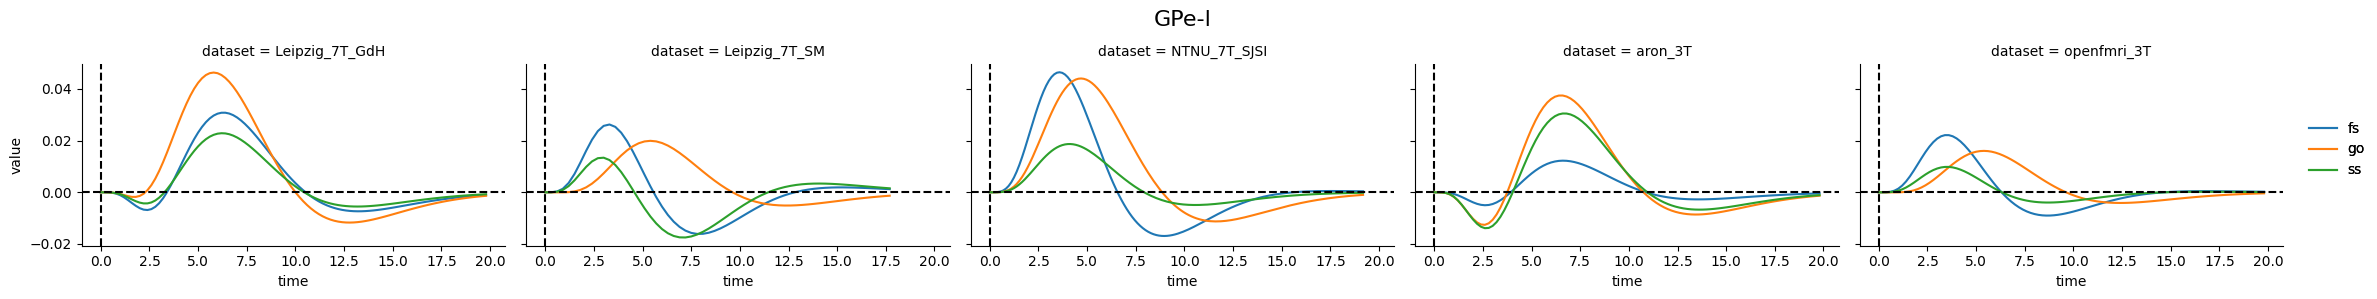

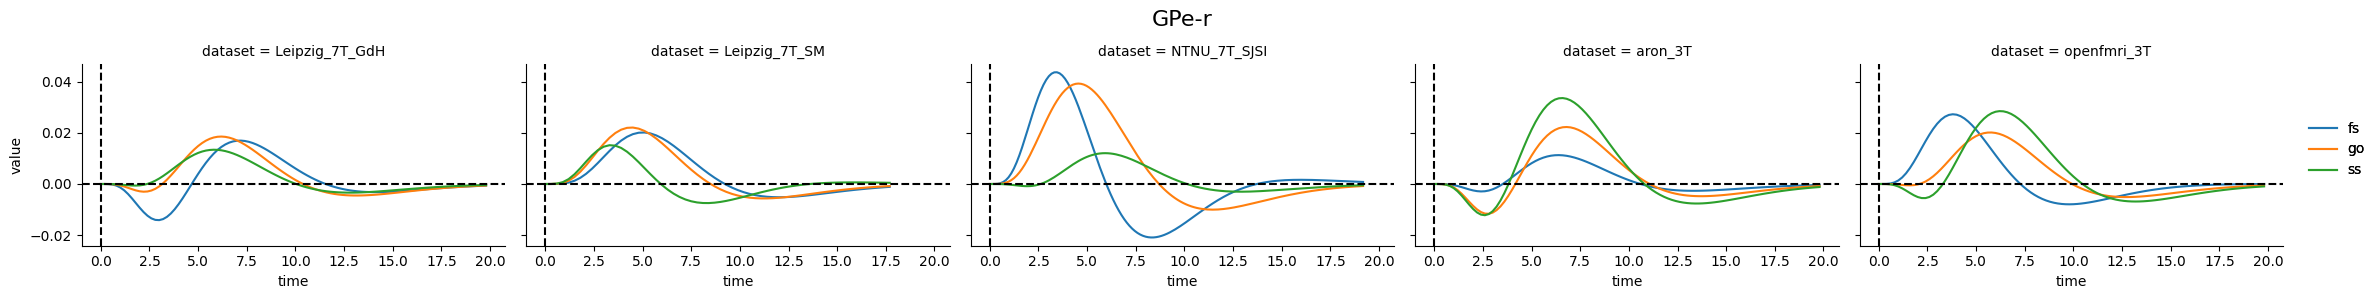

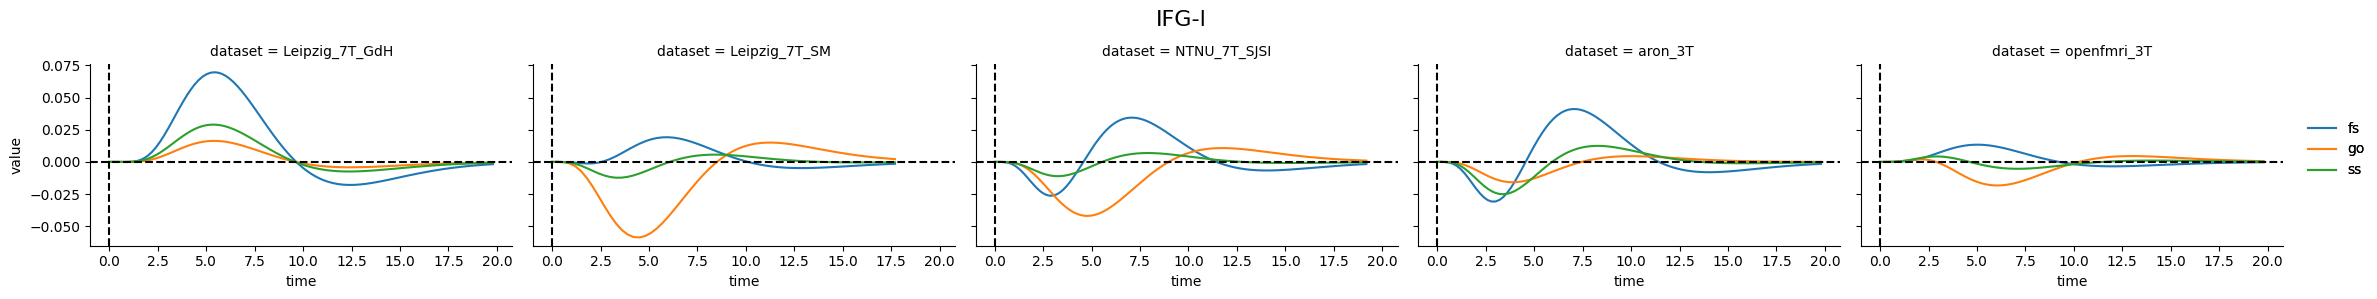

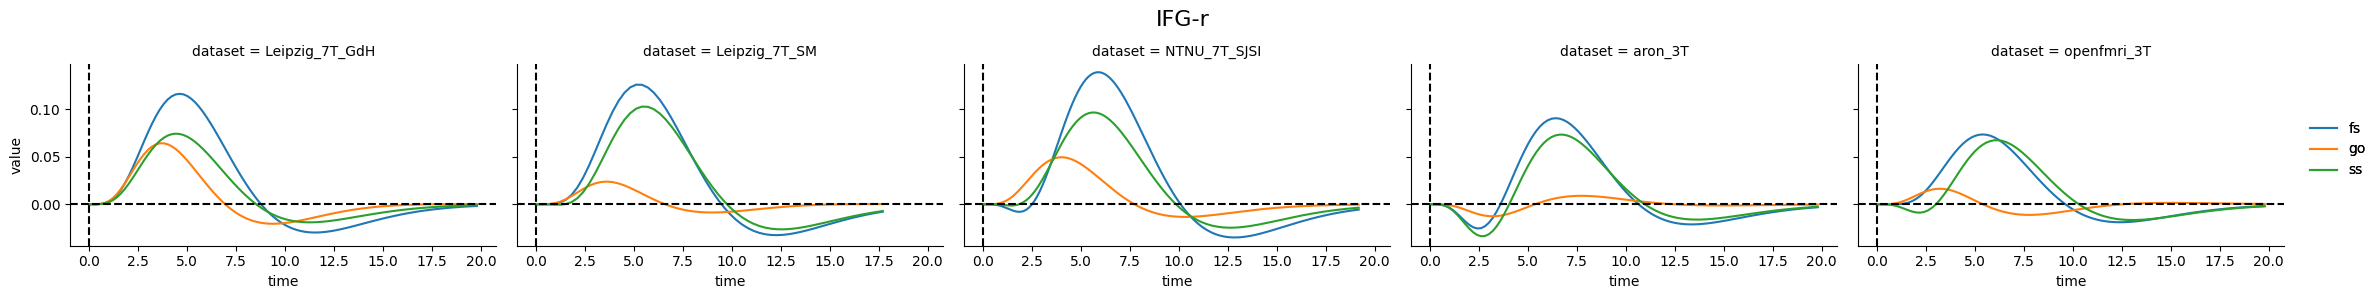

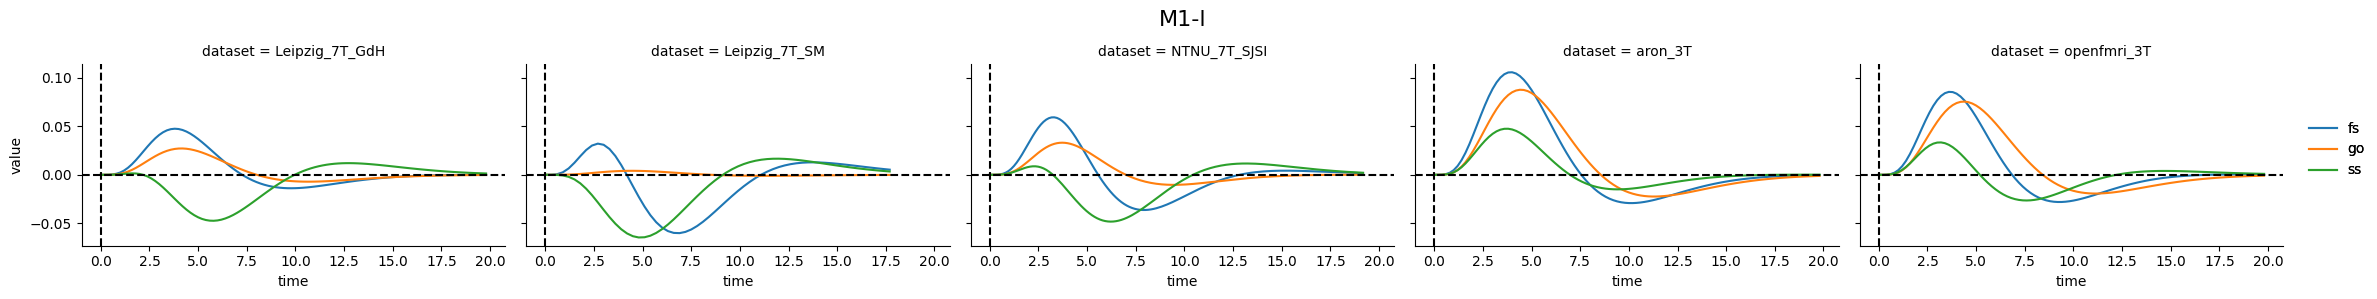

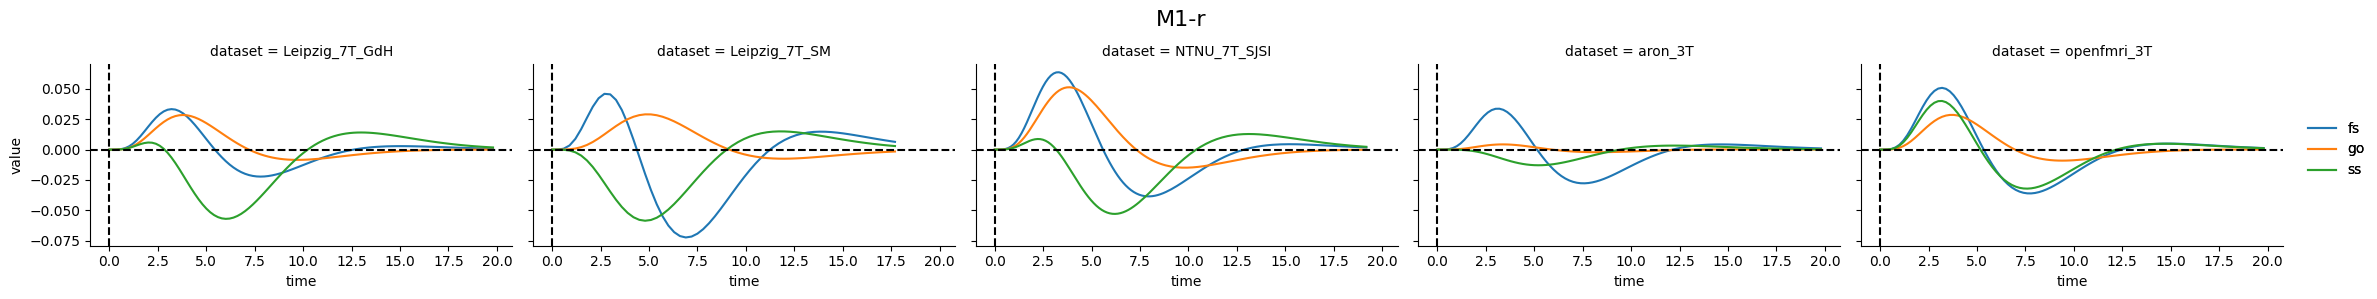

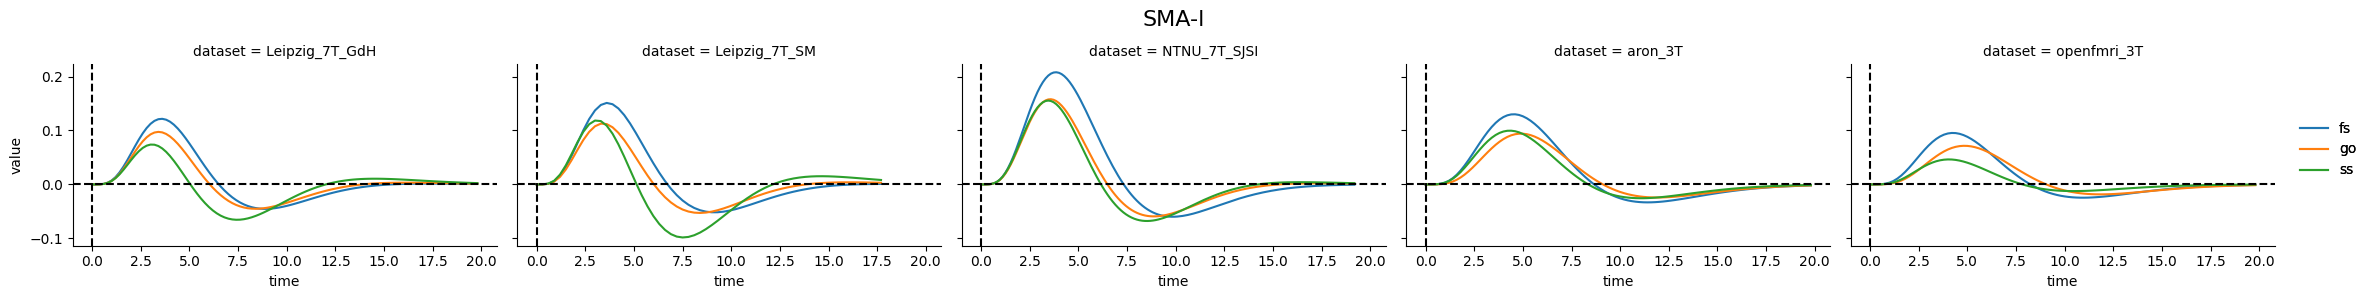

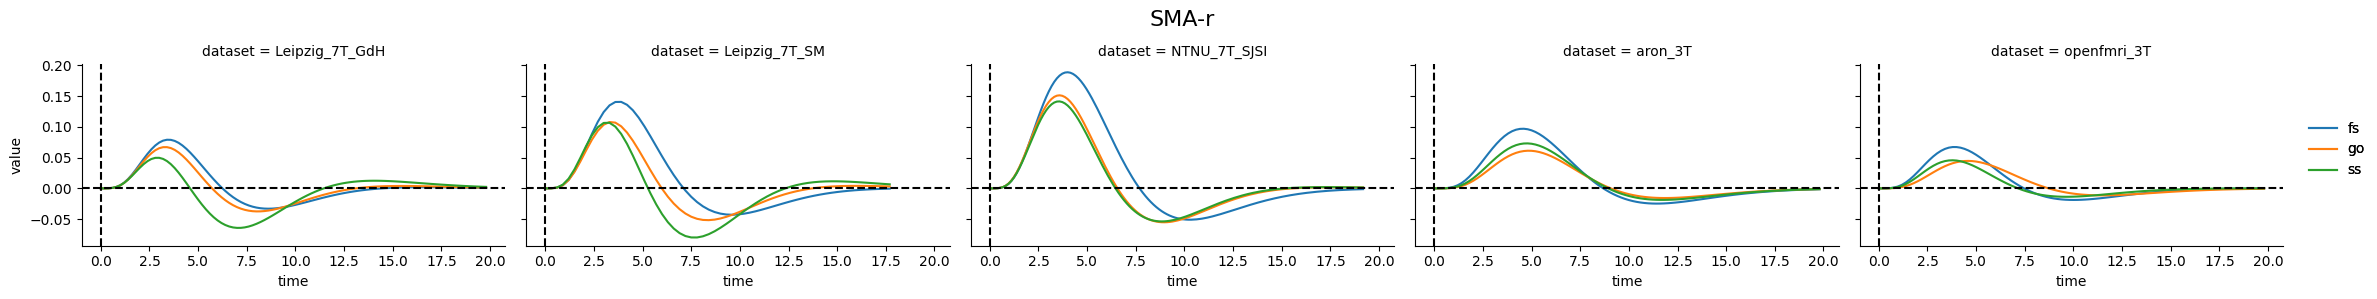

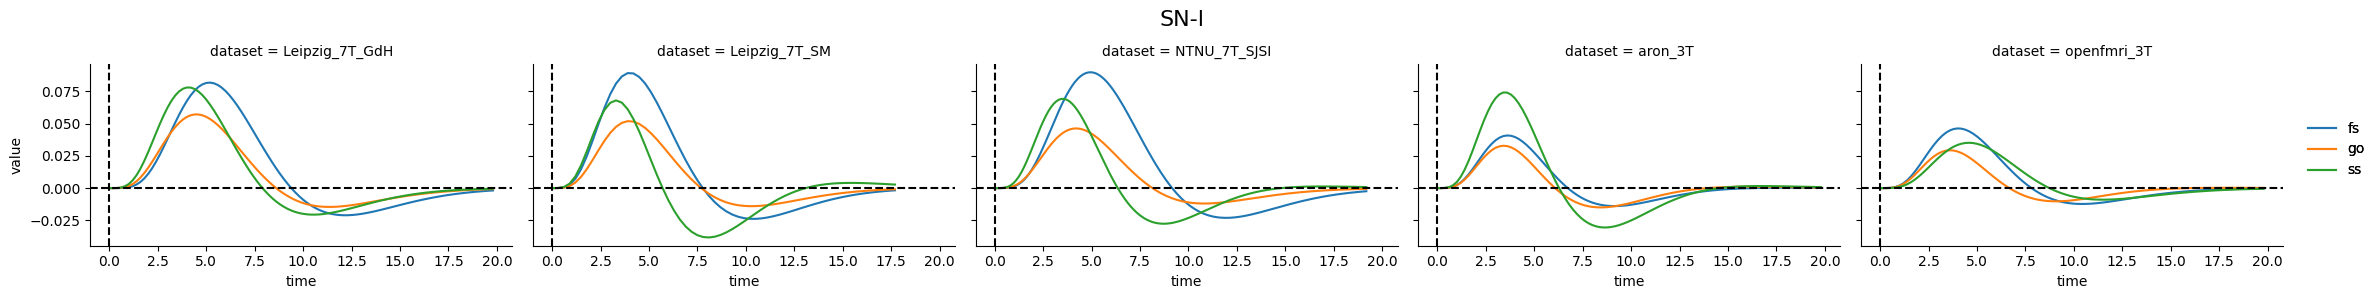

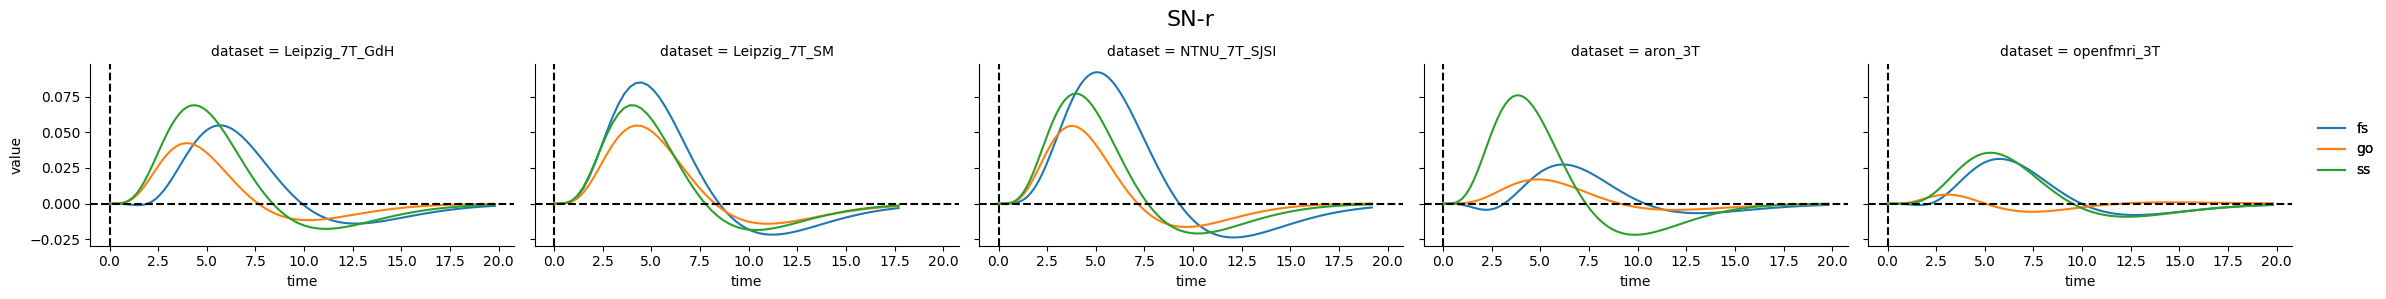

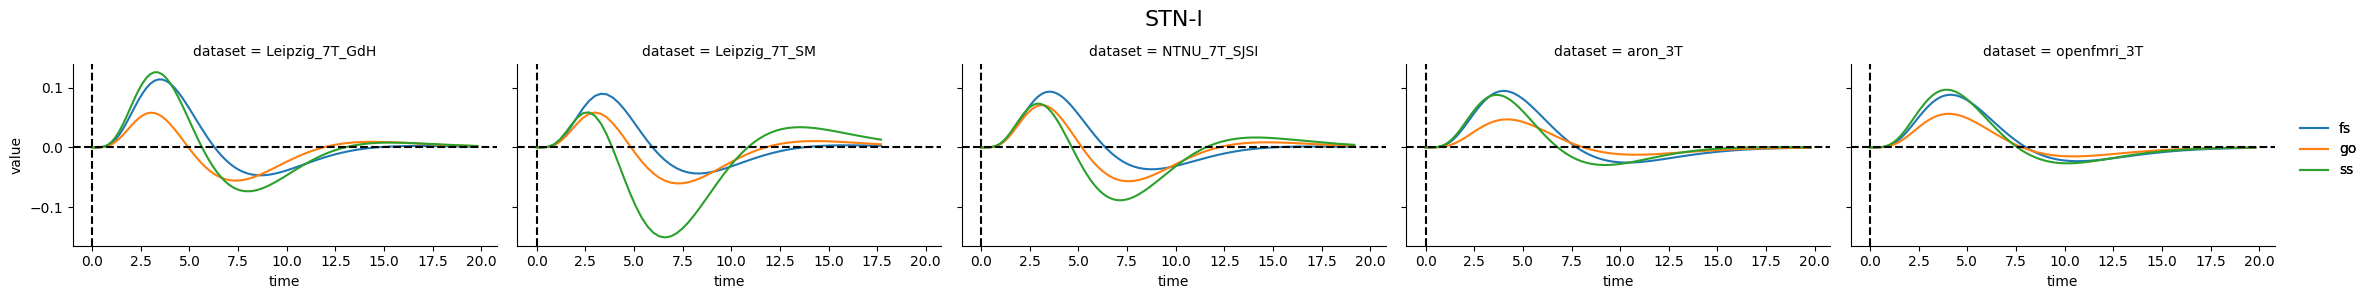

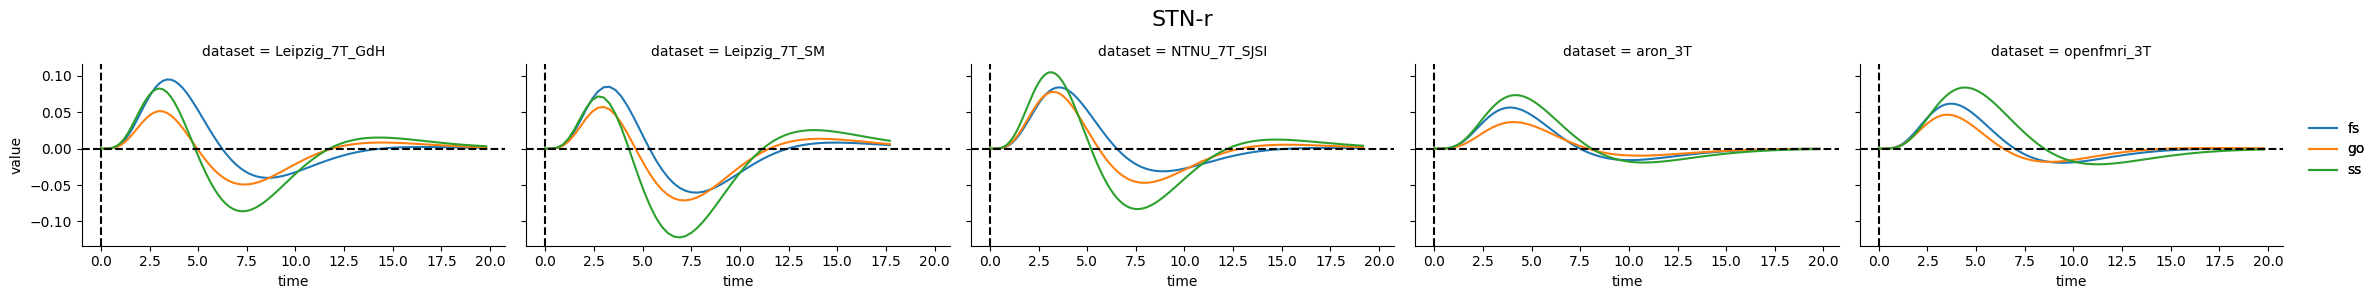

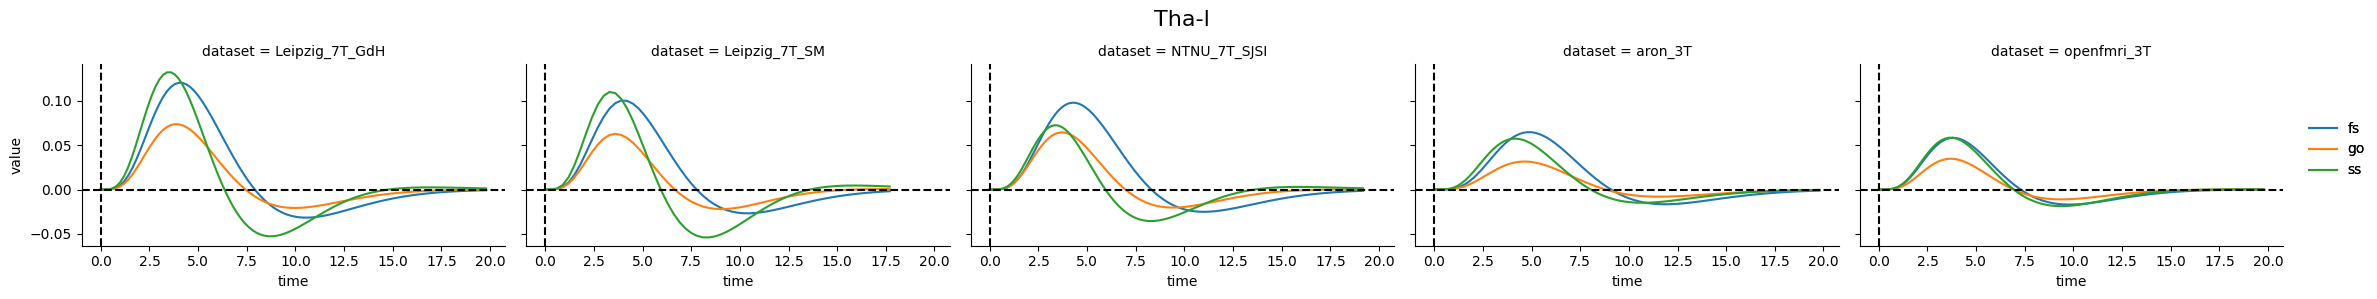

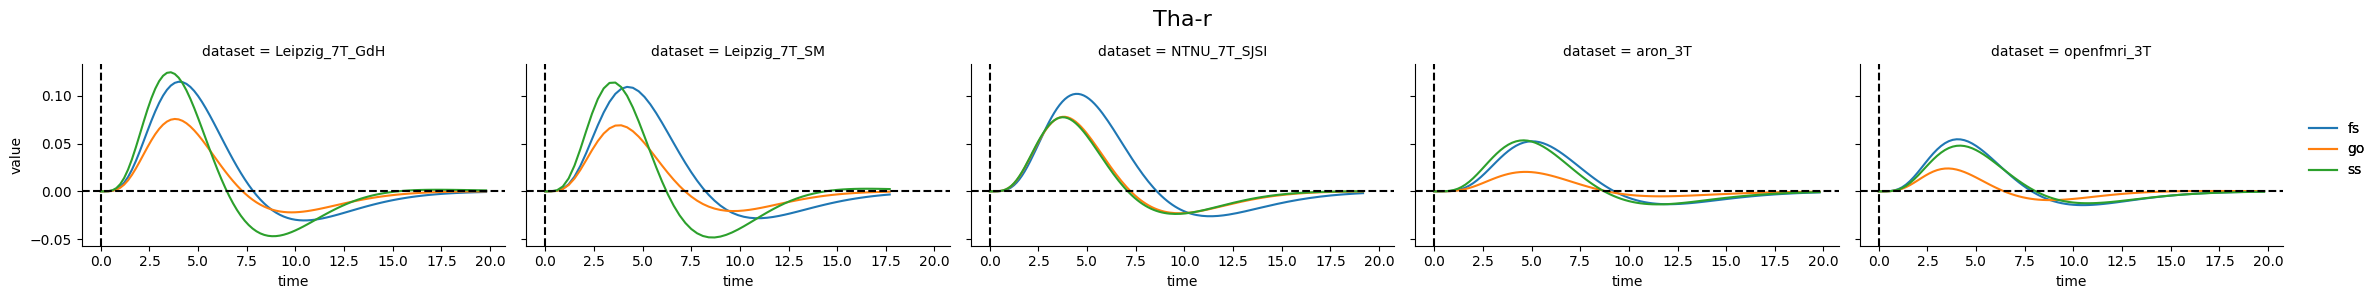

In [9]:
glm1.plot_datasetwise_timecourses(col='dataset',sharey=True)

## sort contrasts

In [10]:
import copy

glm1_ar1 = copy.deepcopy(glm1)
# glm1_ar1 = copy.deepcopy(glm_m)

tc = glm1.get_subjectwise_timecourses()
tc = tc.reset_index().melt(id_vars=['subject', 'event type', 'covariate', 'time'], var_name='roi', value_name='signal')

/home/scotti/miniconda3/envs/nideconv_39/lib/python3.9/site-packages/nideconv/group_analysis.py:348: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tc = tc.reset_index().groupby(


In [11]:
all_betas = glm1.response_fitters.groupby(['dataset','subject', 'run']).apply(lambda x: x.iloc[0].betas)                   # Extract all betas to dataframe

# fs - go
subjectwise_betas = all_betas.groupby(level=[0,1,3,4,5]).mean()                                                    # Mean across runs (fixed-effects)
subjectwise_betas = subjectwise_betas.loc[(slice(None),slice(None),['go', 'fs'], 'intercept', 'HRF')]              # Select only betas of interest

contrast_betas = subjectwise_betas.reset_index(level=[3,4], drop=True).groupby(level=[0,1]).diff()
contrast_betas = contrast_betas.xs('fs',level=2)
contrast_betas = contrast_betas.melt(var_name='ROI', value_name='beta_fsgo', ignore_index=False)

contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[-1])
contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[:-2])
contrast_betas_fsgo = contrast_betas.copy()

# fs - ss
subjectwise_betas = all_betas.groupby(level=[0,1,3,4,5]).mean()                                                    # Mean across runs (fixed-effects)
subjectwise_betas = subjectwise_betas.loc[(slice(None),slice(None),['ss', 'fs'], 'intercept', 'HRF')]              # Select only betas of interest

contrast_betas = subjectwise_betas.reset_index(level=[3,4], drop=True).groupby(level=[0,1]).diff()
contrast_betas = contrast_betas.xs('fs',level=2)
contrast_betas = contrast_betas.melt(var_name='ROI', value_name='beta_fsss', ignore_index=False)

contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[-1])
contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[:-2])
contrast_betas_fsss = contrast_betas.copy()

# ss - go
subjectwise_betas = all_betas.groupby(level=[0,1,3,4,5]).mean()                                                    # Mean across runs (fixed-effects)
subjectwise_betas = subjectwise_betas.loc[(slice(None),slice(None),['go', 'ss'], 'intercept', 'HRF')]              # Select only betas of interest

contrast_betas = subjectwise_betas.reset_index(level=[3,4], drop=True).groupby(level=[0,1]).diff()
contrast_betas = contrast_betas.xs('ss',level=2)
contrast_betas = contrast_betas.melt(var_name='ROI', value_name='beta_ssgo', ignore_index=False)

contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[-1])
contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[:-2])
contrast_betas_ssgo = contrast_betas.copy()

In [22]:
# fs - go
this_contrast = contrast_betas_fsgo.reset_index()
res_fsgo = []
for roi in this_contrast['ROI'].unique():
    
    mdf = smf.ols("beta_fsgo ~ ROI + C(dataset)", data=this_contrast[this_contrast['ROI']==roi]).fit()
    y, t, p, se = mdf.params.Intercept,mdf.tvalues.Intercept,mdf.pvalues.Intercept,mdf.bse.Intercept
    res_fsgo.append([roi,y,t,p,se])
    
res_fsgo = pd.DataFrame(res_fsgo, columns=['roi','y','t','p','se']).set_index('roi')
stat_df = pd.concat([res_fsgo, pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(res_fsgo['p'], method='i'), index=['fdr_significant', 'p_corrected'], columns=res_fsgo.index).T], axis=1)
stat_fsgo = stat_df.loc[sorted(stat_df.index, key=str.casefold)]

# fs - ss
this_contrast = contrast_betas_fsss.reset_index()
res_fsss = []
for roi in this_contrast['ROI'].unique():
    
    mdf = smf.ols("beta_fsss ~ ROI + C(dataset)", data=this_contrast[this_contrast['ROI']==roi]).fit()
    y, t, p, se = mdf.params.Intercept,mdf.tvalues.Intercept,mdf.pvalues.Intercept,mdf.bse.Intercept
    res_fsss.append([roi,y,t,p,se])
    
res_fsss = pd.DataFrame(res_fsss, columns=['roi','y','t','p','se']).set_index('roi')
stat_df = pd.concat([res_fsss, pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(res_fsss['p'], method='i'), index=['fdr_significant', 'p_corrected'], columns=res_fsss.index).T], axis=1)
stat_fsss = stat_df.loc[sorted(stat_df.index, key=str.casefold)]

# ss - go
this_contrast = contrast_betas_ssgo.reset_index()
res_ssgo = []
for roi in this_contrast['ROI'].unique():
    
    mdf = smf.ols("beta_ssgo ~ ROI + C(dataset)", data=this_contrast[this_contrast['ROI']==roi]).fit()
    y, t, p, se = mdf.params.Intercept,mdf.tvalues.Intercept,mdf.pvalues.Intercept,mdf.bse.Intercept
    res_ssgo.append([roi,y,t,p,se])
    
res_ssgo = pd.DataFrame(res_ssgo, columns=['roi','y','t','p','se']).set_index('roi')
print(res_ssgo)
stat_df = pd.concat([res_ssgo, pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(res_ssgo['p'], method='i'), index=['fdr_significant', 'p_corrected'], columns=res_ssgo.index).T], axis=1)
stat_ssgo = stat_df.loc[sorted(stat_df.index, key=str.casefold)]

# add significnace 
for stat in (stat_fsgo, stat_fsss, stat_ssgo):
    stat['significance'] = ''
    stat.loc[stat['p_corrected']<=0.05,'significance']='*'
    stat.loc[stat['p_corrected']<=0.01,'significance']='**'
    stat.loc[stat['p_corrected']<=0.001,'significance']='***'

stat_fsgo, stat_fsss, stat_ssgo = stat_fsgo.reindex(rois_), stat_fsss.reindex(rois_), stat_ssgo.reindex(rois_)


              y         t             p        se
roi                                              
IFG-l  0.015727  1.220164  2.241126e-01  0.012889
IFG-r  0.030803  1.816614  7.105863e-02  0.016956
SMA-l -0.045446 -3.281199  1.257083e-03  0.013850
SMA-r -0.043632 -3.195874  1.665542e-03  0.013653
M1-l  -0.069869 -4.686495  5.716445e-06  0.014908
M1-r  -0.074732 -5.316182  3.335631e-07  0.014057
SN-l   0.015799  0.825678  4.101580e-01  0.019135
SN-r   0.030926  1.578566  1.163167e-01  0.019592
STN-l  0.032259  0.941387  3.478580e-01  0.034268
STN-r -0.017644 -0.524518  6.006098e-01  0.033639
GPe-l -0.022995 -1.755945  8.092009e-02  0.013095
GPe-r -0.002142 -0.163223  8.705389e-01  0.013124
Tha-l  0.012558  1.230550  2.202115e-01  0.010205
Tha-r  0.013542  1.384186  1.681375e-01  0.009784


In [29]:
contrast_betas_ssgo[contrast_betas_ssgo.index.get_level_values(0)=='aron_3T'].groupby('ROI').mean()

/tmp/ipykernel_3175541/3662774794.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  contrast_betas_ssgo[contrast_betas_ssgo.index.get_level_values(0)=='aron_3T'].groupby('ROI').mean()


,beta_ssgo
ROI,
GPe-l,-0.006948
GPe-r,0.012097
IFG-l,0.004400
IFG-r,0.049291
M1-l,-0.049555
M1-r,-0.013025
SMA-l,-0.000949
SMA-r,0.015427
SN-l,0.020403


In [20]:
this_contrast

,dataset,subject,ROI,beta_ssgo,hemisphere,ROI_nohemi
0,Leipzig_7T_GdH,BI3T,IFG-l,-0.009437,l,IFG
1,Leipzig_7T_GdH,FMFT,IFG-l,-0.005261,l,IFG
2,Leipzig_7T_GdH,GAIT,IFG-l,0.080509,l,IFG
3,Leipzig_7T_GdH,KCAT,IFG-l,0.097913,l,IFG
4,Leipzig_7T_GdH,KP6T,IFG-l,-0.072641,l,IFG
...,...,...,...,...,...,...
2417,openfmri_3T,11128,Tha-r,0.005163,r,Tha
2418,openfmri_3T,11131,Tha-r,0.028120,r,Tha
2419,openfmri_3T,11143,Tha-r,0.035418,r,Tha
2420,openfmri_3T,11149,Tha-r,0.028883,r,Tha


In [21]:
res_ssgo

,y,t,p,se
roi,,,,
IFG-l,0.015727,1.220164,2.241126e-01,0.012889
IFG-r,0.030803,1.816614,7.105863e-02,0.016956
SMA-l,-0.045446,-3.281199,1.257083e-03,0.013850
SMA-r,-0.043632,-3.195874,1.665542e-03,0.013653
M1-l,-0.069869,-4.686495,5.716445e-06,0.014908
M1-r,-0.074732,-5.316182,3.335631e-07,0.014057
SN-l,0.015799,0.825678,4.101580e-01,0.019135
SN-r,0.030926,1.578566,1.163167e-01,0.019592
STN-l,0.032259,0.941387,3.478580e-01,0.034268


## show significance

In [14]:
from IPython.display import display_html
from itertools import chain,cycle
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2>{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

In [15]:
display_side_by_side(stat_fsgo,stat_fsss,stat_ssgo, titles=['fs > go','fs > ss','ss > go'])

,y,t,p,se,fdr_significant,p_corrected,significance
roi,,,,,,,
IFG-l,0.053284,3.733697,0.000258,0.014271,True,0.001281,**
IFG-r,0.067066,3.716711,0.000275,0.018045,True,0.001281,**
SMA-l,0.011506,0.719433,0.472874,0.015993,False,0.551686,
SMA-r,0.006826,0.446818,0.655582,0.015276,False,0.706011,
M1-l,0.002294,0.177525,0.859310,0.012922,False,0.85931,
M1-r,-0.024470,-1.688989,0.093077,0.014488,False,0.186153,
SN-l,0.029028,1.397254,0.164180,0.020775,False,0.255391,
SN-r,0.017736,0.884093,0.377909,0.020062,False,0.529073,
STN-l,0.066803,2.152892,0.032754,0.031029,False,0.091711,


## plot all 4 contrasts

In [17]:
import numpy as np
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    #return m, m-h, m+h
    return m+h # only need highest 

def mean_confidence_interval_lower(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    #return m, m-h, m+h
    return m-h # only need highest 

def add_asteriks(ax_n, data, col_name, significance=0):
    l_count, r_count = 0, 0
    
    
#     new = contrast_betas_inccon.groupby(['ROI_nohemi','hemisphere'])['beta_inc-con'].apply(mean_confidence_interval).reset_index().set_index('ROI_nohemi')
#     new = new.loc[sorted(new.index,key=str.casefold)].drop_duplicates().reset_index().set_index(['ROI_nohemi','hemisphere'])
    roi_data = data.groupby(['ROI_nohemi','hemisphere'])[col_name].apply(mean_confidence_interval).reset_index().set_index('ROI_nohemi')
#     roi_data = roi_data.loc[sorted(roi_data.index,key=str.casefold)].drop_duplicates().reset_index().set_index(['ROI_nohemi','hemisphere'])
    roi_data = roi_data.loc[roi_data.index].drop_duplicates().reset_index().set_index(['ROI_nohemi','hemisphere']).reindex(gm_nuclei,level=0)
    
    roi_data_lower = data.groupby(['ROI_nohemi','hemisphere'])[col_name].apply(mean_confidence_interval_lower).reset_index().set_index('ROI_nohemi')
#     roi_data_lower = roi_data_lower.loc[sorted(roi_data_lower.index,key=str.casefold)].drop_duplicates().reset_index().set_index(['ROI_nohemi','hemisphere'])
    roi_data_lower = roi_data_lower.loc[roi_data_lower.index].drop_duplicates().reset_index().set_index(['ROI_nohemi','hemisphere']).reindex(gm_nuclei,level=0)
    
#     print(roi_data_lower)
#     for index, (y_val, region) in enumerate(zip(data.groupby(['ROI_nohemi','hemisphere'])[col_name].apply(mean_confidence_interval), data.ROI.unique())):
    for index, (y_val, region, y_val_lower) in enumerate(zip(roi_data[col_name], data.ROI.unique(), roi_data_lower[col_name])):
#         print(significance)
#         print(region)
        if index%2 == 0:
            x_val = -0.26 + l_count
            l_count+=1
            if (aster:=len(significance[index])) == 2:
                x_val = x_val - 0.06
            elif aster == 3:
                x_val = x_val - 0.12
        else:
            x_val = 0.14 + r_count
            r_count+=1
            if (aster:=len(significance[index])) == 2:
                x_val = x_val - 0.06
            elif aster == 3:
                x_val = x_val - 0.12
        if y_val >= 0:
            ax[ax_n].text(x_val, y_val+0.005, significance[index])
        else:
            ax[ax_n].text(x_val, y_val_lower-0.017, significance[index])

/tmp/ipykernel_3175541/467547863.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_yticklabels(ax[2].get_yticks().round(2),fontsize=20)


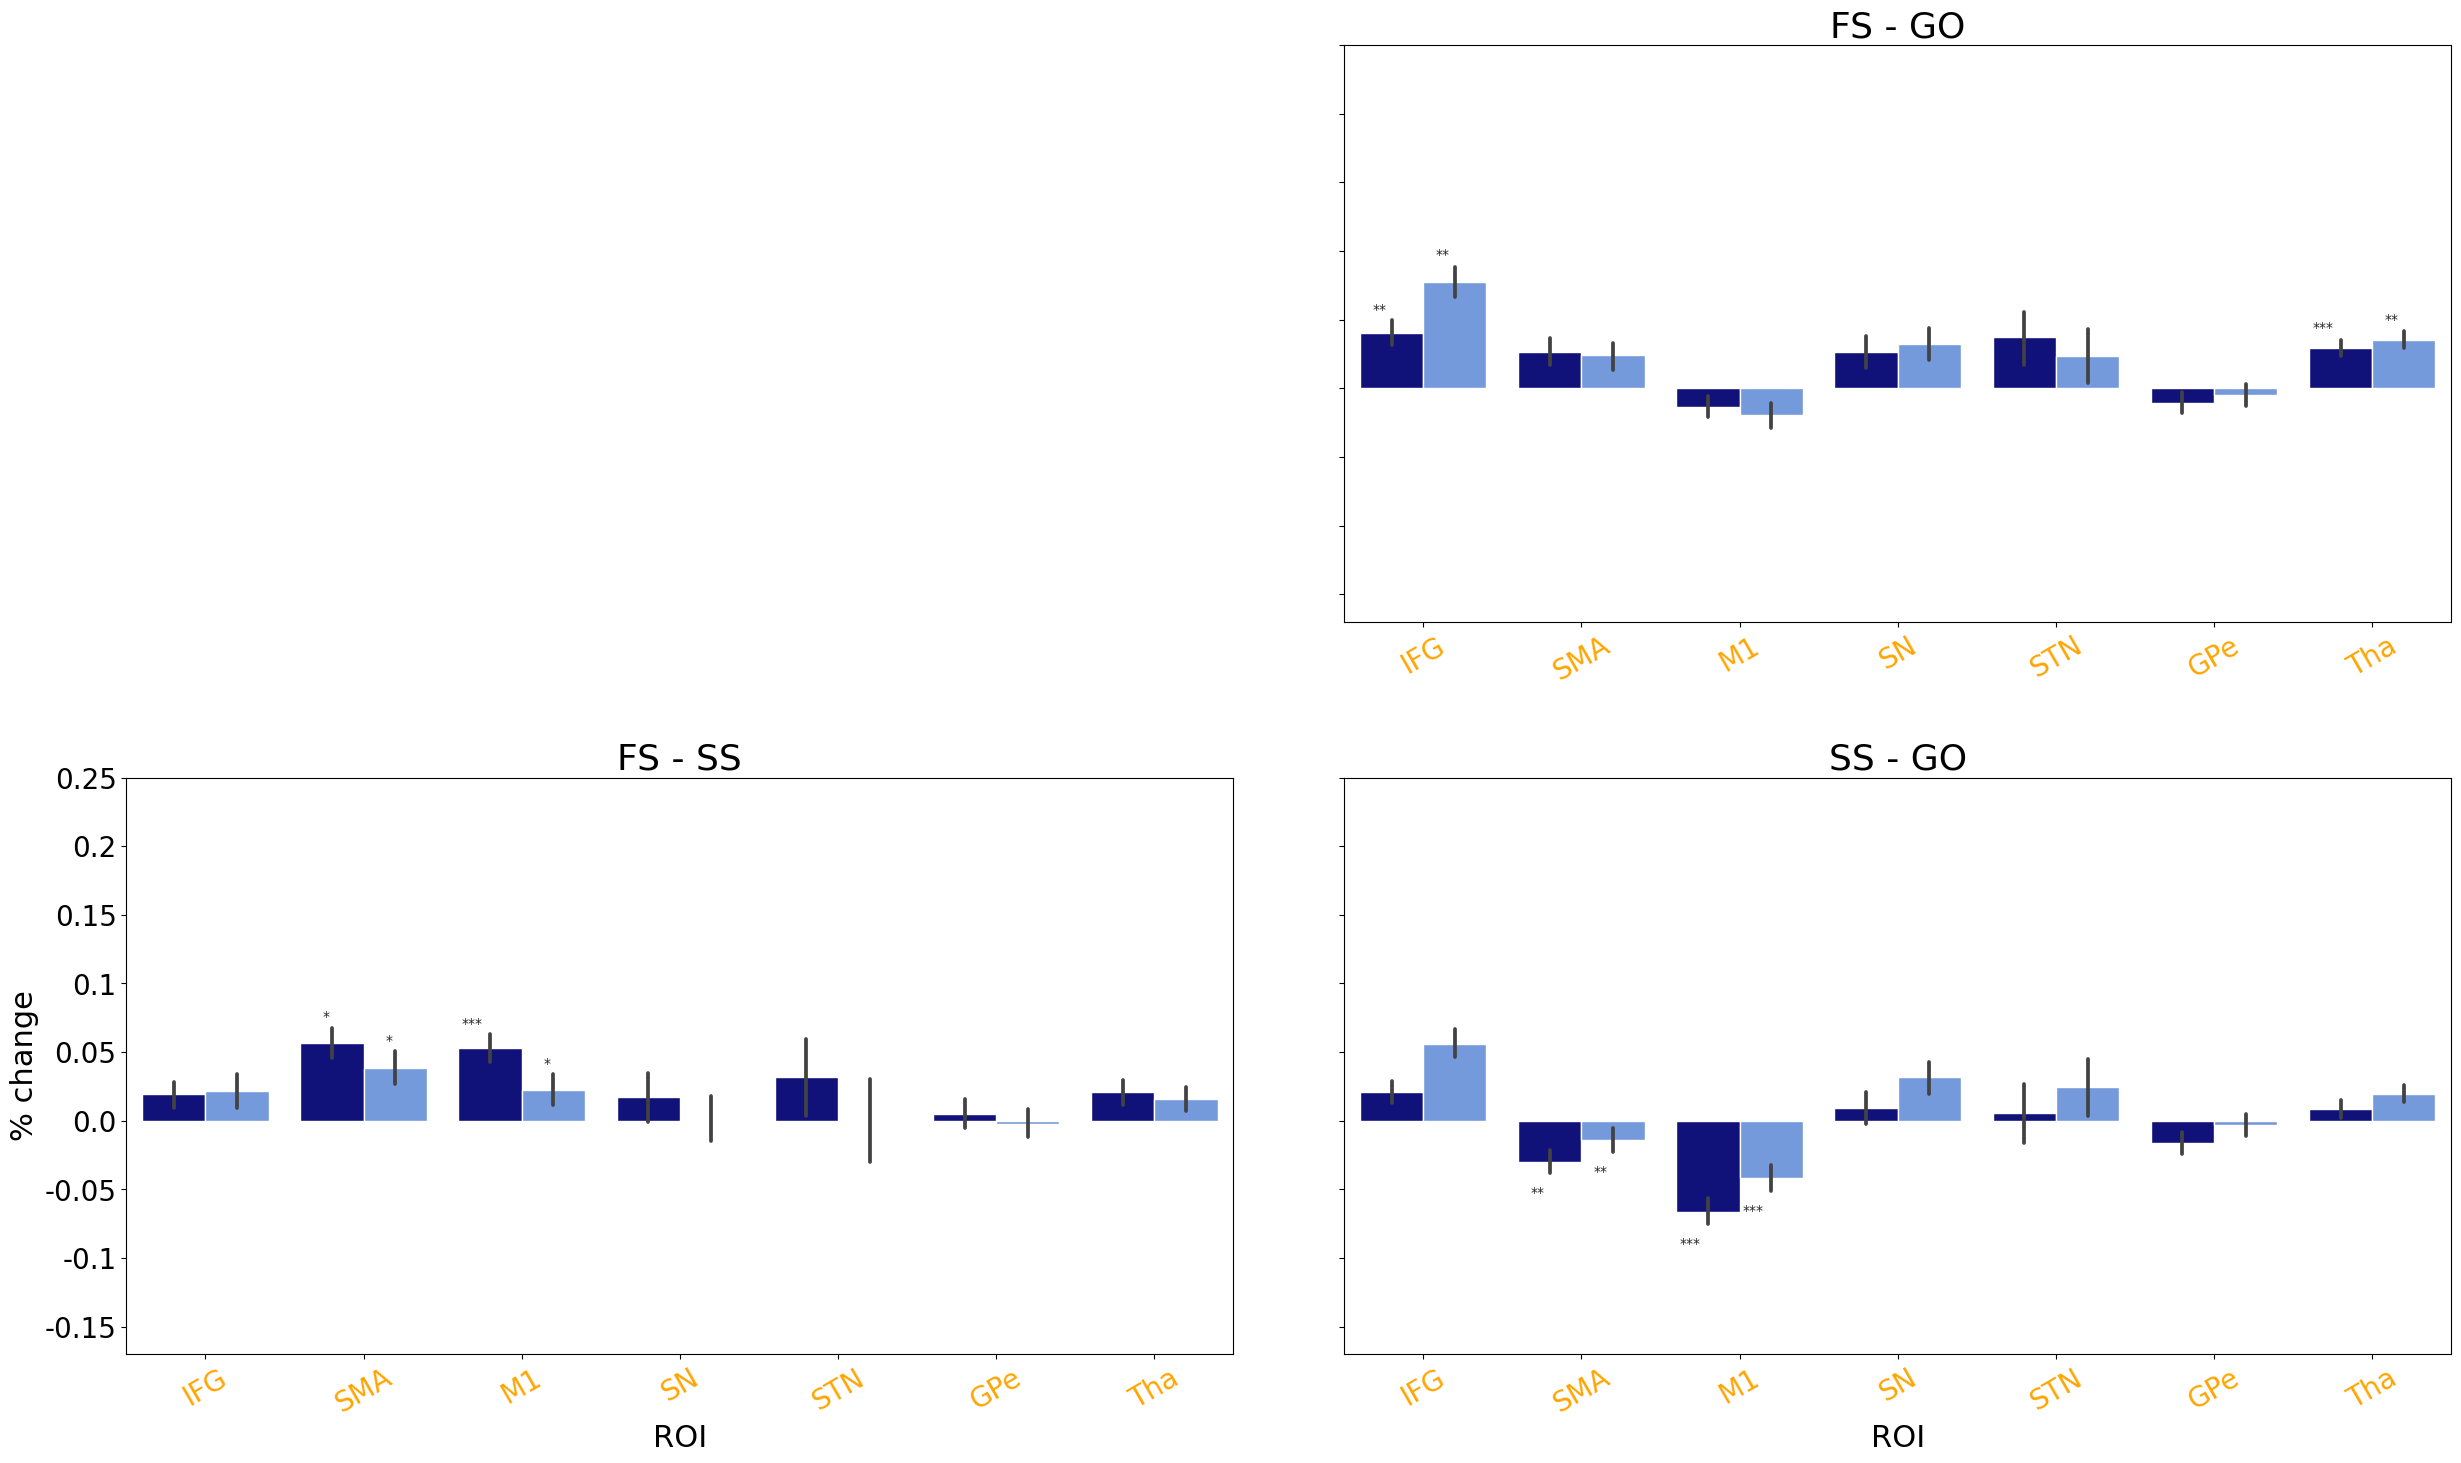

In [18]:
f, axes = plt.subplots(2,2, figsize=(30,17), sharex=False,sharey=True)
ax = axes.ravel()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.27)
# sns.set_style('darkgrid')

with sns.axes_style("whitegrid"):

    ## 2
    sns.barplot(x='ROI_nohemi', y='beta_fsgo', hue='hemisphere', 
                data=contrast_betas_fsgo, ax=ax[1],palette=("darkblue","cornflowerblue"))
    ax[1].set_ylabel('')
    ax[1].set_xlabel('')
    ax[1].legend_.remove()
    ax[1].set_title('FS - GO', fontsize=26)
    ax[1].set(ylim=(-0.17,0.25))
    add_asteriks(1, contrast_betas_fsgo, 'beta_fsgo', stat_fsgo['significance'])
    ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation = 30,fontsize=20)
    # ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation = 30,fontsize=20)
    # ax[1].set_yticklabels(ax[1].get_yticks().round(2),fontsize=20)

    ## 3
    sns.barplot(x='ROI_nohemi', y='beta_fsss', hue='hemisphere', 
                data=contrast_betas_fsss, ax=ax[2],palette=("darkblue","cornflowerblue"))
    ax[2].set_ylabel('% change', fontsize=22)
    ax[2].set_xlabel('ROI', fontsize=22)
    ax[2].legend_.remove()
    ax[2].set_title('FS - SS', fontsize=26)
    ax[2].set(ylim=(-0.17,0.25))
    add_asteriks(2, contrast_betas_fsss, 'beta_fsss', stat_fsss['significance'])
    ax[2].set_xticklabels(ax[2].get_xticklabels(),rotation = 30,fontsize=20)
    ax[2].set_yticklabels(ax[2].get_yticks().round(2),fontsize=20)

    ## 4
    sns.barplot(x='ROI_nohemi', y='beta_ssgo', hue='hemisphere', 
                data=contrast_betas_ssgo, ax=ax[3],palette=("darkblue","cornflowerblue"))
    ax[3].set_ylabel('')
    ax[3].set_xlabel('ROI', fontsize=22)
    ax[3].legend_.remove()
    ax[3].set_title('SS - GO', fontsize=26)
    ax[3].set(ylim=(-0.17,0.25))
    add_asteriks(3, contrast_betas_ssgo, 'beta_ssgo', stat_ssgo['significance'])
    ax[3].set_xticklabels(ax[3].get_xticklabels(),rotation = 30,fontsize=20)
    # ax[3].set_yticklabels(ax[3].get_yticks().round(2),fontsize=20)

    for x in range(4) :[t.set_color(i) for (i,t) in zip(['orange']*7+['red']*8,ax[x].get_xticklabels())]
        
    ax[0].set_visible(False)

#     f.savefig('figure_download_scott/GLM_ROI_SST_contrasts.pdf', bbox_inches='tight')

NameError: name 'betas_fs' is not defined

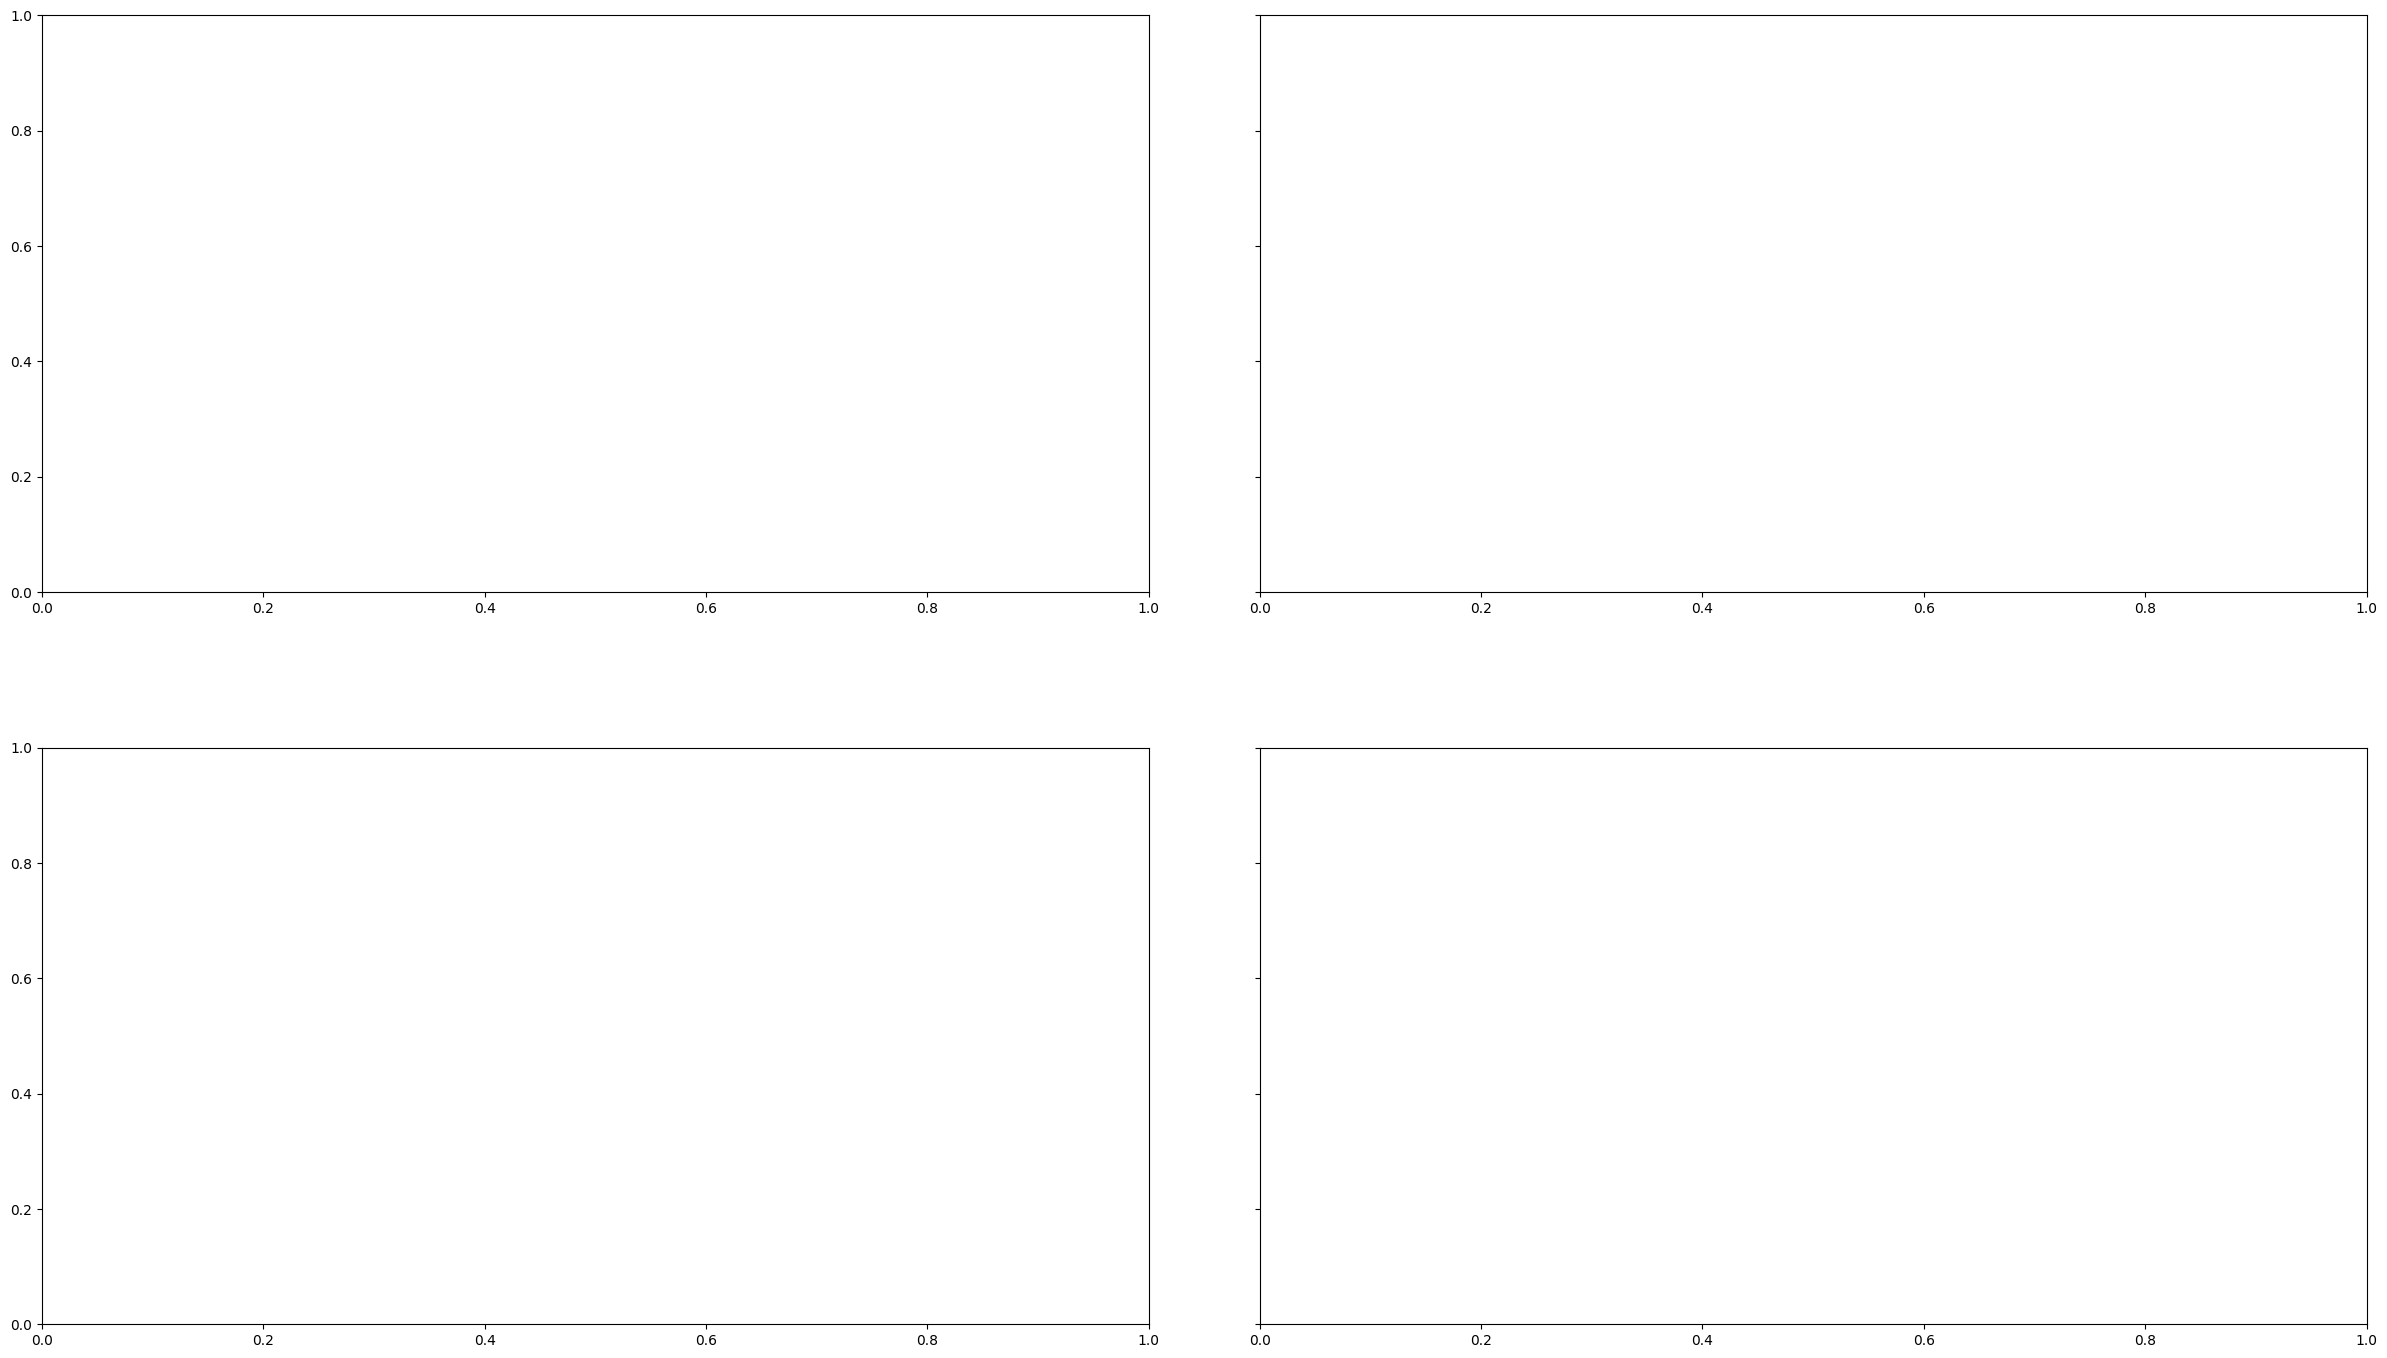

In [38]:
f, axes = plt.subplots(2,2, figsize=(30,17), sharex=False,sharey=True)
ax = axes.ravel()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.27)
# sns.set_style('darkgrid')

with sns.axes_style("whitegrid"):

    ## 1 ## FS
    sns.barplot(x='ROI_nohemi', y='beta_fs', hue='hemisphere', 
                data=betas_fs, ax=ax[0],palette=("darkblue","cornflowerblue"))
    ax[0].set_ylabel('% change', fontsize=22)
    ax[0].set_xlabel('')
    ax[0].legend_.remove()
    ax[0].set_title('FS', fontsize=26)
    ax[0].set(ylim=(-0.15,0.35))
    add_asteriks(0, betas_fs, 'beta_fs', stat_fs['significance'])
    # ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation = 30,fontsize=20)
    ax[0].set_yticklabels(ax[0].get_yticks().round(2),fontsize=20)
    ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation = 30,fontsize=20)

    ## 2 SS
    sns.barplot(x='ROI_nohemi', y='beta_ss', hue='hemisphere', 
                data=betas_ss, ax=ax[1],palette=("darkblue","cornflowerblue"))
    ax[1].set_ylabel('')
    ax[1].set_xlabel('')
    ax[1].legend_.remove()
    ax[1].set_title('SS', fontsize=26)
    ax[1].set(ylim=(-0.15,0.35))
    add_asteriks(1, betas_ss, 'beta_ss', stat_ss['significance'])
    ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation = 30,fontsize=20)

    ## 3 GO
    sns.barplot(x='ROI_nohemi', y='beta_go', hue='hemisphere', 
                data=betas_go, ax=ax[2],palette=("darkblue","cornflowerblue"))
    ax[2].set_ylabel('% change', fontsize=22)
    ax[2].set_xlabel('', fontsize=22)
    ax[2].legend_.remove()
    ax[2].set_title('GO', fontsize=26)
    ax[2].set(ylim=(-0.15,0.35))
    add_asteriks(2, betas_go, 'beta_go', stat_go['significance'])
    # ax[2].set_xticklabels(ax[2].get_xticklabels(),rotation = 30,fontsize=20)
    ax[2].set_yticklabels(ax[2].get_yticks().round(2),fontsize=20)
    ax[2].set_xticklabels(ax[2].get_xticklabels(),rotation = 30,fontsize=20)
    
    for x in range(4) :[t.set_color(i) for (i,t) in zip(['orange']*7+['red']*8,ax[x].get_xticklabels())]
        
    ax[3].set_visible(False)
    
#     f.savefig('figure_download_scott/GLM_ROI_SST_supplementary.pdf', bbox_inches='tight')